# Exploratory NLP on chat messages in pilot data
- This specifically analyzes the tagged noun phrases identified by Justin and Julia

To do:
-- try different tokenizer to deal with punctuation?
-- bag of tower model (tower pairs: group L/C and C/L)
    for each pair, compare first and last occurance of a specific BOT
    interested in words that drop out and words that increase in frequency
-- fix dictionary to be union not intersection
-- TFIDF for tower specific 
    what are the specific words we use to describe tower pairs
-- condition on rep 1, use same langauge for all three items, do subjects disambiguate by the later trials

-- compare probability of words for L-pi and L-C in early and late stages (factor out the "L") 

[X] try tf-idf with LC as doc 1 and LP,CP combined as doc 2 in final rep 

## Import packages

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from collections import Counter
from num2words import num2words
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import matutils, models
import matplotlib.pyplot as plt

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import pickle
import re
import math


stemmer = SnowballStemmer("english")

## Import data frames (generated in DF_generator script from mongoDB)

In [4]:
df= pd.read_csv('../results/csv/JJ_content.csv')

In [5]:
df = df.groupby(['repNum'])['content'].apply(lambda x: ' '.join(x)).reset_index()


### Remove stopwords

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['BOW_clean'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [7]:
import num2words
from num2words import num2words
def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

In [8]:
df['BOW_clean'] = df['BOW_clean'].apply(lambda x: num_2_words(x))

In [9]:
df['BOW_clean'] = df['BOW_clean'].str.lower()
df['BOW_clean'] = df['BOW_clean'].str.replace(r'~', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\(', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\)', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\,', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\'", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\:", '')
df.head(2)

,repNum,content,BOW_clean
0,0,"a blue block a blue block a red block, another red a red block, another red L shape, 2x blue, 2x red L shape, 2x blue, 2x red a blue block a blue block that last blue block last blue block a red block a red block another red block another red block two blue blocks two blue blocks a blue block a blue block another blue block another blue block two red blocks two red blocks a blue block a blue block two red blocks two red blocks a blue block a blue block a red block, another red block, two blues a red block, another red block the other blue the other blue blue, 2 reds blue, 2 reds blue block, elongated ""C."" blue block, elongated ""C"" the red block red block the red block red block a red red a blue block a blue block a blue block a blue block 2 blue blocks 2 blue blocks a red block, another, (an ""L"") a red block, another red block red block a red block a red block a blue a blue a blue a blue the L, the two blue blocks L, two blue blocks a blue block a blue block, square two reds two re...","blue block blue block red block another red red block another red l shape 2x blue 2x red l shape 2x blue 2x red blue block blue block last blue block last blue block red block red block another red block another red block two blue blocks two blue blocks blue block blue block another blue block another blue block two red blocks two red blocks blue block blue block two red blocks two red blocks blue block blue block red block another red block two blues red block another red block blue blue blue two reds blue two reds blue block elongated ""c."" blue block elongated ""c"" red block red block red block red block red red blue block blue block blue block blue block two blue blocks two blue blocks red block another an ""l"" red block another red block red block red block red block blue blue blue blue l two blue blocks l two blue blocks blue block blue block square two reds two reds blue ""c"" blue c tower horizontal two piece block horizontal two piece block veritcal two piece block vertical tw..."
1,1,"a red, another red, 2 blues a red, another red, 2 blues a blue, 2x red, another blue a blue, 2x red, another blue tall c-shape, tall L-shape tall c-shape, tall L-shape the last blue the last blue L, upsidedown U shape L, upsidedown U shape upside down U, 2x red, 2x blue upside down U,2x red, 2x blue the last block the last block C tower, blue C tower, blue L tower, two blues, 2 reds L tower, two blues on each side, 2 reds L tower, blue L tower, blues on each side 2 reds, arch shape 2 reds on each side Arch shape, C shape Arch shape, C shape, blue V blk V blk H blk H blk V blk V blk H blk H blk H blk H blk H blk H blk V blk V blk V blk V blk H blk H blk v blk V blk V blk V blk H blk H blk H blk H blk H blk H blk V blk V blk V blk V blk H blk H blk H blk H blk H blk H blk V blk V blk v v h h H blk H blk H blk H blk V blk V blk v v small n small n C C up n, L n, L L L C,L C, L L L C, One horizontal C, one horizontal One more vertical vertical an L, Two horizontal blocks L, two horizo...",red another red two blues red another red two blues blue 2x red another blue blue 2x red another blue tall c-shape tall l-shape tall c-shape tall l-shape last blue last blue l upsidedown u shape l upsidedown u shape upside u 2x red 2x blue upside u2x red 2x blue last block last block c tower blue c tower blue l tower two blues two reds l tower two blues side two reds l tower blue l tower blues side two reds arch shape two reds side arch shape c shape arch shape c shape blue v blk v blk h blk h blk v blk v blk h blk h blk h blk h blk h blk h blk v blk v blk v blk v blk h blk h blk v blk v blk v blk v blk h blk h blk h blk h blk h blk h blk v blk v blk v blk v blk h blk h blk h blk h blk h blk h blk v blk v blk v v h h h blk h blk h blk h blk v blk v blk v v small n small n c c n l n l l l cl c l l l c one horizontal c one horizontal one vertical vertical l two horizontal blocks l two horizontal blocks arch c arch c arch l arch l blue b

## lemmatize

In [10]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
df['BOW_lemmatized'] = df['BOW_clean'].apply(lemmatize_text)
df.head(1)

,repNum,content,BOW_clean,BOW_lemmatized
0,0,"a blue block a blue block a red block, another red a red block, another red L shape, 2x blue, 2x red L shape, 2x blue, 2x red a blue block a blue block that last blue block last blue block a red block a red block another red block another red block two blue blocks two blue blocks a blue block a blue block another blue block another blue block two red blocks two red blocks a blue block a blue block two red blocks two red blocks a blue block a blue block a red block, another red block, two blues a red block, another red block the other blue the other blue blue, 2 reds blue, 2 reds blue block, elongated ""C."" blue block, elongated ""C"" the red block red block the red block red block a red red a blue block a blue block a blue block a blue block 2 blue blocks 2 blue blocks a red block, another, (an ""L"") a red block, another red block red block a red block a red block a blue a blue a blue a blue the L, the two blue blocks L, two blue blocks a blue block a blue block, square two reds two re...","blue block blue block red block another red red block another red l shape 2x blue 2x red l shape 2x blue 2x red blue block blue block last blue block last blue block red block red block another red block another red block two blue blocks two blue blocks blue block blue block another blue block another blue block two red blocks two red blocks blue block blue block two red blocks two red blocks blue block blue block red block another red block two blues red block another red block blue blue blue two reds blue two reds blue block elongated ""c."" blue block elongated ""c"" red block red block red block red block red red blue block blue block blue block blue block two blue blocks two blue blocks red block another an ""l"" red block another red block red block red block red block blue blue blue blue l two blue blocks l two blue blocks blue block blue block square two reds two reds blue ""c"" blue c tower horizontal two piece block horizontal two piece block veritcal two piece block vertical tw...","[blue, block, blue, block, red, block, another, red, red, block, another, red, l, shape, 2x, blue, 2x, red, l, shape, 2x, blue, 2x, red, blue, block, blue, block, last, blue, block, last, blue, block, red, block, red, block, another, red, block, another, red, block, two, blue, block, two, blue, block, blue, block, blue, block, another, blue, block, another, blue, block, two, red, block, two, red, block, blue, block, blue, block, two, red, block, two, red, block, blue, block, blue, block, red, block, another, red, block, two, blue, red, block, another, red, block, blue, blue, blue, two, red, blue, two, red, ...]"


In [11]:
df['BOW_lemmatized'] = df['BOW_lemmatized'].apply(lambda x: [i.upper() for i in x] )

In [12]:
df_grouped = df.groupby('repNum').agg({'BOW_lemmatized': 'sum'})

## plot most common words in rep0 and rep3

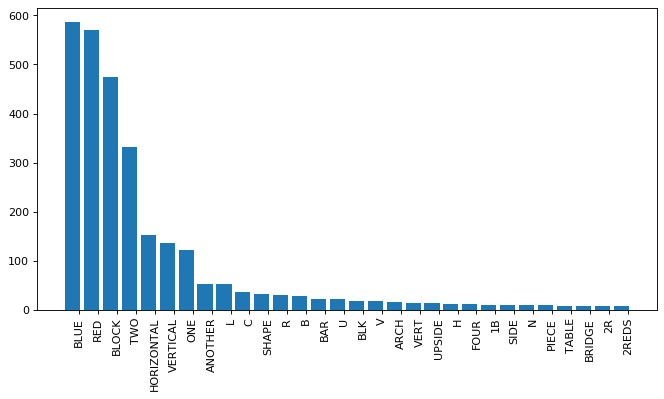

In [13]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

from collections import Counter
x_limit = 30

word_list = df_grouped['BOW_lemmatized'].iloc[0]

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

In [14]:
total = sum(counts.values())

rep_0 = {k: v / total for k, v in counts.items()}

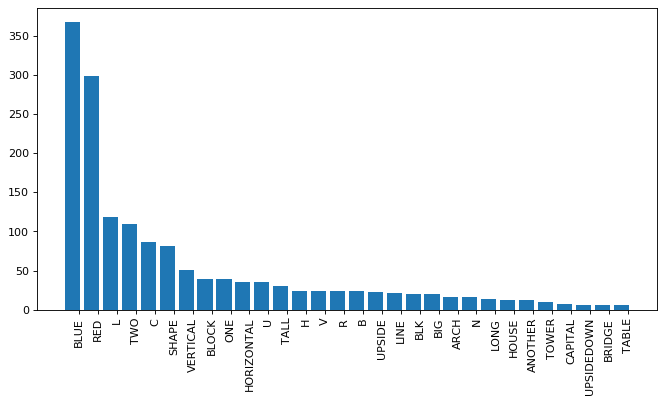

In [15]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 30

word_list = df_grouped['BOW_lemmatized'].iloc[3]

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

In [16]:
total = sum(counts.values())

rep_3 = {k: v / total for k, v in counts.items()}

## Create dictionary of difference in proportions

In [34]:
d_diff = {key: rep_3[key] - rep_0.get(key, 0) for key in rep_3}

In [33]:
print(rep_0['BLUE'])
print(rep_0['RED'])
print(rep_3['BLUE'])
print(rep_3['RED'])

0.18848504342232228
0.18333869411386297
0.21007441327990842
0.17115054378935318


In [26]:
len(d_diff.keys())

119

## Plot change in proportions of words from rep0 to rep3

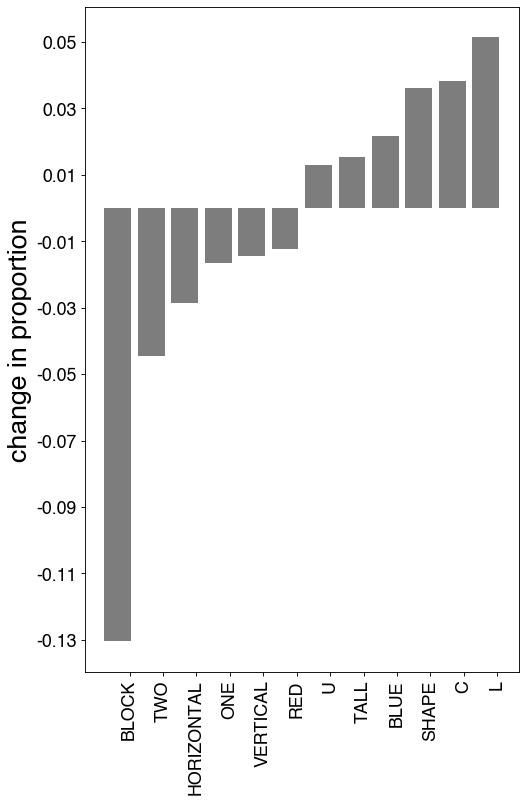

<Figure size 432x288 with 0 Axes>

In [35]:
from matplotlib.ticker import FormatStrFormatter

font = {'fontname':'Helvetica'}

x_limit = 6

labels, values = zip(*d_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

fig = plt.figure(num=None, figsize=(7, 11), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.bar(indexes, values, color = "#7D7D7D")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# add labels
plt.yticks(fontsize=16, **font)
plt.xticks(indexes + bar_width, labels,  rotation='vertical', fontsize=16, **font)
plt.ylabel("change in proportion", size = 24, **font)
plt.yticks(np.arange(-.13,.06, .02))
ax.axes.get_xaxis().set_visible(True)
#plt.title("highest delta words", size = 24, **font)
plt.show()
plt.savefig('../results/plots/ORLR_word_delta_hist.pdf')

## Build Towerset specific BOW separated by first and last rep

In [229]:
CL_0 = df.loc[(df['C'] == 1) & (df['L'] == 1), 'BOW_clean'].iloc[0].split()
CL_3 = df.loc[(df['C'] == 1) & (df['L'] == 1), 'BOW_clean'].iloc[3].split()
LP_0 = df.loc[(df['L'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[0].split()
LP_3 = df.loc[(df['L'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3].split()
CP_0 = df.loc[(df['C'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[0].split()
CP_3 = df.loc[(df['C'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3].split()


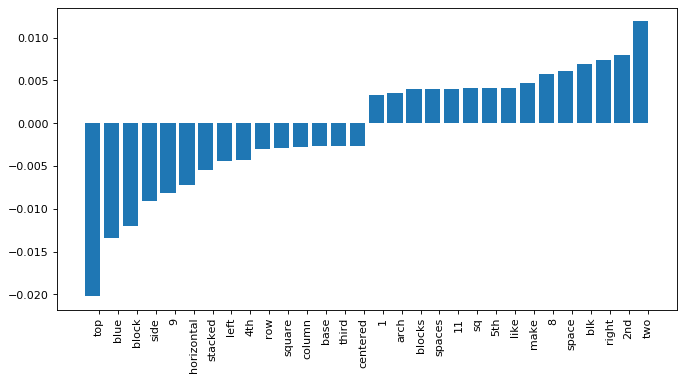

In [233]:
set1, set2 = CL_0, LP_0

#Get word counts for first set
counts = Counter(set1)
total = sum(counts.values())
d1 = {k: v / total for k, v in counts.items()}
#Get word counts for CL3
counts = Counter(set2)
total = sum(counts.values())
d2 = {k: v / total for k, v in counts.items()}
labels, values = zip(*counts.items())

#Get difference in count dicts
d_diff = {key: d2[key] - d1.get(key, 0) for key in d2}


#Plot difference
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 15

labels, values = zip(*d_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange the data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

## WORD CLOUD!
perhaps pointless, but definitely fun!

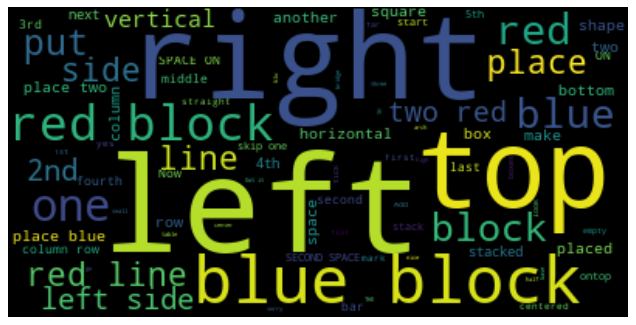

In [159]:
from wordcloud import WordCloud
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
wordcloud = WordCloud().generate(df['BOW_clean'].iloc[1])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Try TF-IDF with tower specific docs

In [214]:
CP_3 = df.loc[(df['C'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3]
CL_3 = df.loc[(df['C'] == 1) & (df['L'] == 1), 'BOW_clean'].iloc[3]
LP_3 = df.loc[(df['L'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3]

doc1 = "hello this this this this this two five ten"
doc2 = "Other thing this this this this this two hello else"

vectorizer = TfidfVectorizer(sublinear_tf = True)
vectors = vectorizer.fit_transform([doc1,doc2])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_vectors = pd.DataFrame(denselist, columns=feature_names)

Tops = pd.DataFrame(df_vectors.apply(lambda x:list(df_vectors.columns[np.array(x).argsort()[::-1][:15]]), axis=1).to_list())

Tops

,0,1,2,3,4,5,6,7
0,this,ten,five,two,hello,thing,other,else
1,this,thing,other,else,two,hello,ten,five


In [212]:
len(doc1)

839